# Execute all versions of lid driven cavity problem

In [3]:
from pathlib import Path
from xml.etree import ElementTree
path = "bin"
programs = {
    "Lid driven cavity": ("SparseLUWrapper", "SparseLUWrapper"),
    "Lid driven cavity QR GPU": ("QR", "SparseLUWrapper"),
    # "Lid driven cavity iterative GPU" : "lidDrivenIterativeGPU" # useless...
    "Lid driven cavity GPU with DSS" : ("DSS", "SparseLUWrapper"),
    "Lid driven cavity GPU with DSS and RF" : ("DSS", "RF")
}
hs = [h/1000.0 for h in range(20, 2, -2)]

Create parameter files

In [4]:
def get_output_path(program, h):
    return Path("benchmark", f"lidDriven_{program}_{int(h*1000):0>2}_result.h5")
def get_param_path(program, h):
    return Path("..", "params", "benchmark", f"chanelFlow_{program}_{int(h*1000):0>2}.xml")

In [5]:
parameter_path = Path("..", "params")
default_param = parameter_path / "chanelFlow.xml"
for name, (solver_u, solver_p) in programs.items():
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for h in hs:
        num_xml = root.find("./num")
        num_xml.set('h', str(h))
        case_xml = root.find("./case")
        case_xml.set('solver_u', solver_u)
        case_xml.set('solver_p', solver_p)
        output = root.find("./output")
        output.set("hdf5_name", str(Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)))
        param_output_path = get_param_path(f"{solver_u}_{solver_p}", h)
        params_tree.write(param_output_path)

Run program for every parameter file

In [6]:
import subprocess
from concurrent.futures.process import ProcessPoolExecutor
def run_lid_driven(param_file):
    subprocess.run(["../bin/lidDriven", param_file])
parameter_dir = Path("..", "params", "benchmark")
to_run = []
for param_file in parameter_dir.glob("*.xml"):
    params_tree = ElementTree.parse(param_file)
    root = params_tree.getroot()
    output_xml = root.find("./output")
    output_path = Path(output_xml.get("hdf5_name"))
    if Path.exists(output_path):
        continue
    to_run.append(param_file)
with ProcessPoolExecutor(4) as pool:
    pool.map(run_lid_driven, to_run)


Display benchmarking results

In [7]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

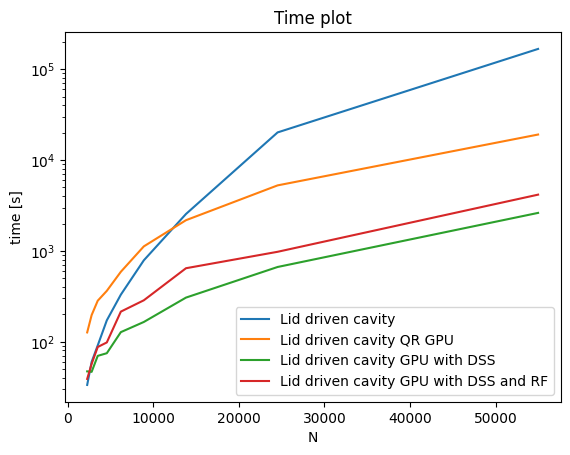

In [18]:
fig, ax = plt.subplots()
for name, (solver_u, solver_p) in programs.items():
    ts = []
    Ns = []
    for h in hs:
        result_file = Path("..") / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            time = f.attrs["time"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
plt.yscale('log')
ax.set_title("Time plot")
ax.legend()

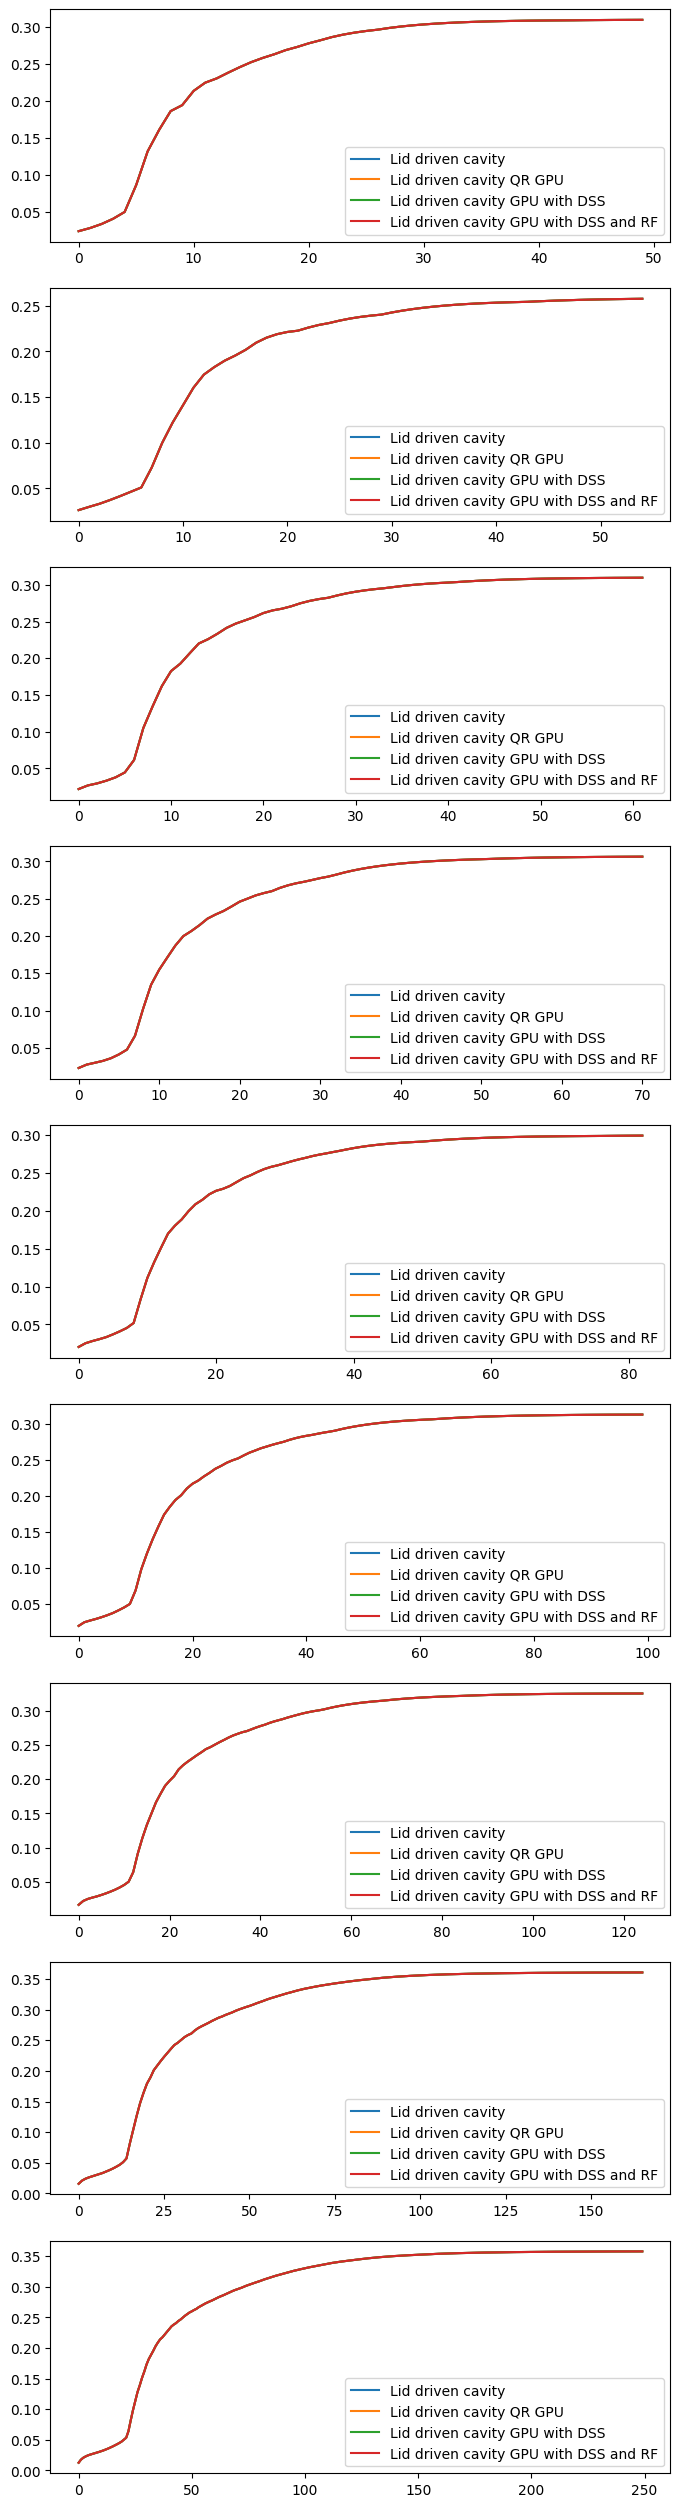

In [9]:
fig, axs = plt.subplots(len(hs), figsize=(8,32))
for i, h in enumerate(hs):
    for name, (solver_u, solver_p) in programs.items():
        result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            velocity = np.array(f['max_u_y'], dtype=np.float64)
            xs = list(range(len(velocity[0])))
            axs[i].plot(xs, velocity[0], label=name)
            axs[i].legend()